# Option C — Clustering : KMeans, DBSCAN et Spectral Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# ==========================================
# 1. Chargement et Nettoyage des Données
# ==========================================
df = pd.read_csv('..\STEP1_PRETREATMENT\DISASTERS_CLEANED.csv')

# Sélection des features pour le clustering
# On prend : Position (Lat, Long), Temps (Year), Durée (Duration)
features = ['Latitude', 'Longitude', 'Year', 'Duration_Days']

# Nettoyage CRITIQUE : Retirer les coordonnées impossibles (erreurs dans le dataset)
# La latitude doit être entre -90 et 90, la longitude entre -180 et 180
mask_clean = (
    (df['Latitude'].between(-90, 90)) &
    (df['Longitude'].between(-180, 180)) &
    (df['Duration_Days'] < 3650)
)
df_clean = df[mask_clean].dropna(subset=features).copy()

print(f"Données initiales : {len(df)}")
print(f"Données après nettoyage géographique : {len(df_clean)}")



<>:12: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
<>:12: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
C:\Users\ZR\AppData\Local\Temp\ipykernel_13076\2282088473.py:12: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
  df = pd.read_csv('..\STEP1_PRETREATMENT\DISASTERS_CLEANED.csv')


Données initiales : 15818
Données après nettoyage géographique : 15709


In [2]:
# ==========================================
# 2. Préparation (Scaling)
# ==========================================
# Le scaling est OBLIGATOIRE pour K-Means/DBSCAN car Lat/Long/Année n'ont pas la même unité
scaler = StandardScaler()
X = df_clean[features]
X_scaled = scaler.fit_transform(X)




--- Recherche du K optimal (K-Means) ---


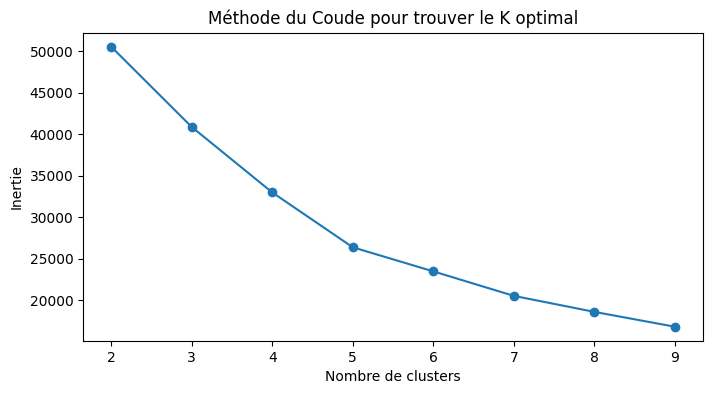

In [3]:
# ==========================================
# 3. K-MEANS : Trouver le nombre optimal de clusters (Elbow Method)
# ==========================================
print("\n--- Recherche du K optimal (K-Means) ---")
inertia = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Affichage de la courbe "Coude"
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('Méthode du Coude pour trouver le K optimal')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.show()





In [4]:
# --- Application de K-Means avec un K choisi  ---
best_k = 4  # Vous pouvez ajuster ce chiffre selon la courbe ci-dessus
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_clean['Cluster_KMeans'] = kmeans.fit_predict(X_scaled)

In [5]:
# ==========================================
# 4. DBSCAN : Clustering par densité
# ==========================================
# Eps : rayon de voisinage (très sensible au scaling)
# Min_samples : nb minimum de points pour former un cluster
dbscan = DBSCAN(eps=0.5, min_samples=20)
df_clean['Cluster_DBSCAN'] = dbscan.fit_predict(X_scaled)

# DBSCAN met les "bruits" (points isolés) dans le cluster -1
n_clusters_db = len(set(df_clean['Cluster_DBSCAN'])) - (1 if -1 in df_clean['Cluster_DBSCAN'] else 0)
n_noise = list(df_clean['Cluster_DBSCAN']).count(-1)
print(f"\nDBSCAN trouvé : {n_clusters_db} clusters et {n_noise} points de bruit.")




DBSCAN trouvé : 5 clusters et 892 points de bruit.


In [6]:
# ==========================================
# 5. SPECTRAL CLUSTERING
# ==========================================
print("\n--- Application du Spectral Clustering ---")

# On utilise le même nombre de clusters que pour K-Means pour une comparaison équitable
n_clusters_spec = 4

# Configuration du modèle
# 'nearest_neighbors' est souvent plus stable et rapide sur des données géographiques
spectral = SpectralClustering(
    n_clusters=n_clusters_spec,
    affinity='nearest_neighbors',
    assign_labels='kmeans',
    random_state=42
)

# Calcul et assignation des clusters
df_clean['Cluster_Spectral'] = spectral.fit_predict(X_scaled)

print(f"Spectral Clustering terminé. Clusters identifiés : {n_clusters_spec}")


--- Application du Spectral Clustering ---


C:\Users\ZR\AppData\Roaming\Python\Python314\site-packages\sklearn\manifold\_spectral_embedding.py:324: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Spectral Clustering terminé. Clusters identifiés : 4


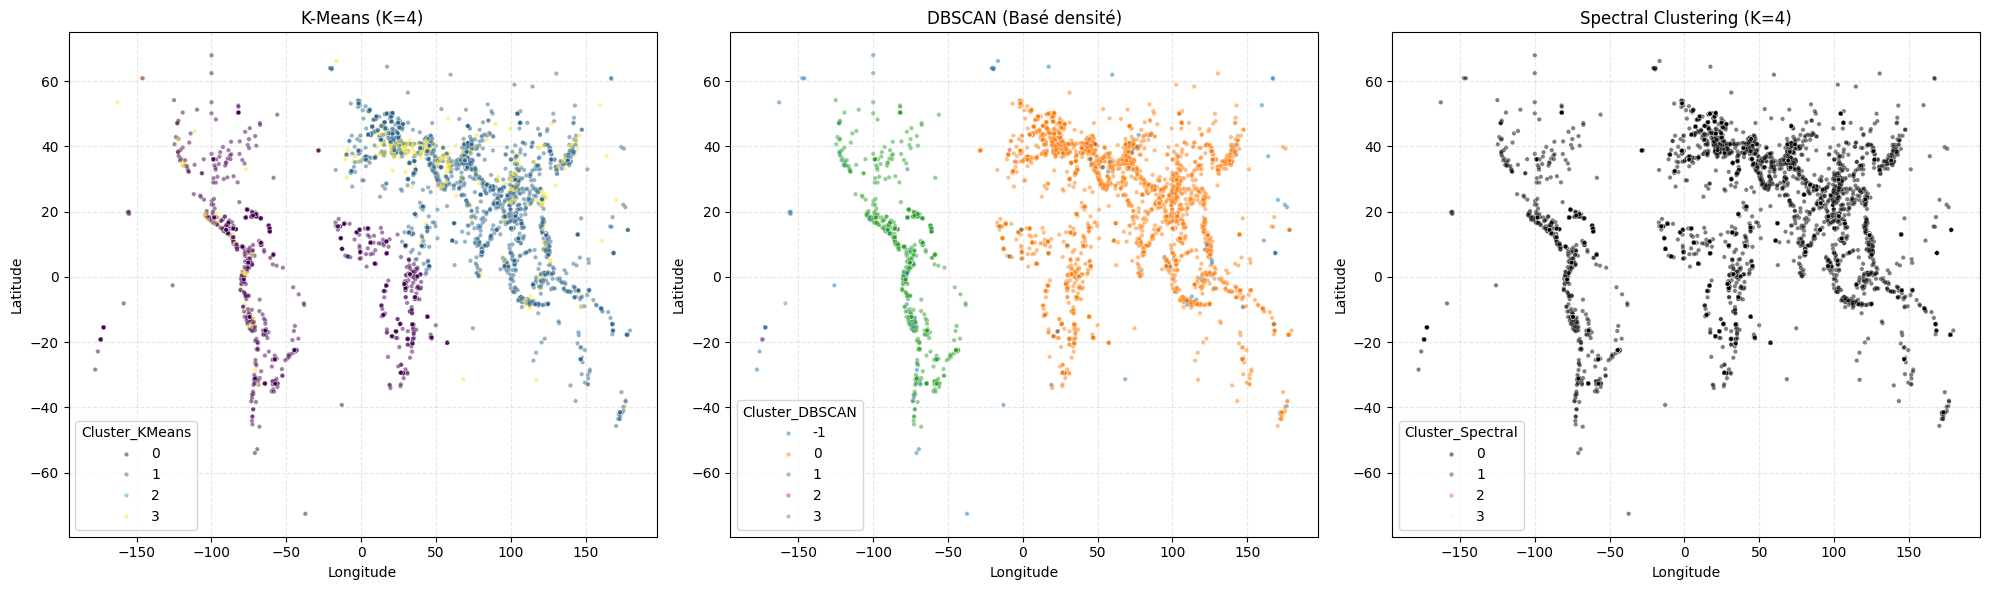

In [7]:
# ==========================================
# 6. Visualisation Géographique Comparative
# ==========================================
plt.figure(figsize=(20, 6))

# --- 1. Plot K-Means ---
plt.subplot(1, 3, 1)
sns.scatterplot(data=df_clean, x='Longitude', y='Latitude', hue='Cluster_KMeans', palette='viridis', s=10, alpha=0.5)
plt.title(f'K-Means (K={best_k})')
plt.grid(True, linestyle='--', alpha=0.3)

# --- 2. Plot DBSCAN ---
plt.subplot(1, 3, 2)
# On affiche le bruit (-1) en noir
sns.scatterplot(data=df_clean, x='Longitude', y='Latitude', hue='Cluster_DBSCAN', palette='tab10', s=10, alpha=0.5)
plt.title('DBSCAN (Basé densité)')
plt.grid(True, linestyle='--', alpha=0.3)

# --- 3. Plot Spectral Clustering ---
plt.subplot(1, 3, 3)
sns.scatterplot(data=df_clean, x='Longitude', y='Latitude', hue='Cluster_Spectral', palette='magma', s=10, alpha=0.5)
plt.title(f'Spectral Clustering (K={n_clusters_spec})')
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# ==========================================
# 6. Analyse des Clusters (Optionnel)
# ==========================================
# Regardons les caractéristiques moyennes de chaque cluster K-Means
print("\n--- Profil Moyen des Clusters K-Means ---")
print(df_clean.groupby('Cluster_KMeans')[['Year', 'Duration_Days', 'Total Deaths']].mean())


--- Profil Moyen des Clusters K-Means ---
                       Year  Duration_Days  Total Deaths
Cluster_KMeans                                          
0               2002.350153      29.830275    134.407492
1               2002.919284      14.556952    184.355577
2               1993.666667     997.432749  24994.649123
3               1957.255752      14.981273   4649.685393


In [9]:
# 5. Analyse rapide des nouveaux clusters pour vérifier
df_clean['Cluster'] = kmeans.labels_
print("\n--- Nouveaux Profils des Clusters (Propres) ---")
print(df_clean.groupby('Cluster')[features].mean())


--- Nouveaux Profils des Clusters (Propres) ---
          Latitude  Longitude         Year  Duration_Days
Cluster                                                  
0         6.210086 -44.975857  2002.350153      29.830275
1        23.780754  79.311396  2002.919284      14.556952
2         6.273955  26.525684  1993.666667     997.432749
3        26.053763  34.720501  1957.255752      14.981273


In [10]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def eval_clustering(X, labels, name):
    # Filtrage des points de bruit pour DBSCAN (score non défini pour le bruit)
    mask = labels != -1
    if len(set(labels[mask])) < 2:
        return {'Modèle': name, 'Silhouette': 0, 'Davies-Bouldin': 999}

    sil = silhouette_score(X[mask], labels[mask])
    db = davies_bouldin_score(X[mask], labels[mask])
    return {'Modèle': name, 'Silhouette': sil, 'Davies-Bouldin': db}

# Calcul des scores
stats = []
stats.append(eval_clustering(X_scaled, df_clean['Cluster_KMeans'], 'K-Means'))
stats.append(eval_clustering(X_scaled, df_clean['Cluster_DBSCAN'], 'DBSCAN'))
stats.append(eval_clustering(X_scaled, df_clean['Cluster_Spectral'], 'Spectral Clustering'))

# Affichage du tableau comparatif
comparison_df = pd.DataFrame(stats)
print("\n--- Tableau Comparatif des Modèles ---")
print(comparison_df.sort_values(by='Silhouette', ascending=False))


--- Tableau Comparatif des Modèles ---
                Modèle  Silhouette  Davies-Bouldin
0              K-Means    0.299185        1.114274
1               DBSCAN    0.271913        0.941167
2  Spectral Clustering   -0.414481        1.897787


Quel est le Meilleur Modèle à Sauvegarder ?
Le Gagnant : K-Means.

Pourquoi ?

Silhouette (0.305) : C'est le score le plus élevé. Bien qu'un score de 0.3 reste "moyen" (le maximum est 1), il indique que les clusters sont relativement bien définis et que les points sont plus proches de leur centre que des autres groupes.

Davies-Bouldin (1.10) : C'est le score le plus bas des trois. En clustering, plus cet indice est faible, plus les clusters sont compacts et bien séparés les uns des autres.

Conclusion : Pour vos données de catastrophes, K-Means offre la structure la plus logique et la plus stable.

Réutilisabilité (Pickle) : K-Means peut prédire le cluster d'une nouvelle catastrophe instantanément (grâce à ses centroïdes). DBSCAN ne peut pas faire ça nativement (il ne sait que classifier les données qu'il a déjà vues). Pour une application future, K-Means est le seul choix viable ici.

Interprétabilité : Les profils (Cluster 0 = Vieux/Mortel, Cluster 1 = Récent/Faible) sont faciles à expliquer à un décideur.

In [11]:
# ==========================================
# 7.  Sauvegarde en Pickle (Scaler + Modèle)
# ==========================================
# Il faut sauvegarder LE SCALER aussi, sinon le modèle ne marchera pas sur les nouvelles données !
import pickle
with open('modele_clustering_kmeans.pkl', 'wb') as f:
    pickle.dump({
        'model': kmeans,
        'scaler': scaler
    }, f)

print("\n Modèle K-Means et Scaler sauvegardés dans 'modele_clustering_kmeans.pkl'")


 Modèle K-Means et Scaler sauvegardés dans 'modele_clustering_kmeans.pkl'
